**You may need to install [OpenCV](https://pypi.python.org/pypi/opencv-python) and [scikit-video](http://www.scikit-video.org/stable/).**

In [1]:
!pip install scikit-video

     |████████████████████████████████| 2.3MB 8.5MB/s 


In [2]:
import keras
import numpy as np
import io
import base64
from IPython.display import HTML
import skvideo.io
import cv2
import json

from keras.models import Sequential,model_from_json
from keras.layers.core import Dense
from keras.optimizers import sgd, adam, rmsprop
from keras.layers import Conv2D, MaxPooling2D, Activation, AveragePooling2D,Reshape,BatchNormalization

from keras.layers import Dropout, Flatten
from random import randint

Using TensorFlow backend.


# MiniProject on Deep Reinforcement Learning

__Notations__: $E_p$ is the expectation under probability $p$. Please justify each of your answer and widely comment your code.

# Context

In a reinforcement learning algorithm, we modelize each step $t$ as an action $a_t$ obtained from a state $s_t$, i.e. $\{(a_{t},s_{t})_{t\leq T}\}$ having the Markov property. We consider a discount factor $\gamma \in [0,1]$ that ensures convergence. The goal is to find among all the policies $\pi$, one that maximizes the expected reward:

\begin{equation*}
R(\pi)=\sum_{t\leq T}E_{p^{\pi}}[\gamma^t r(s_{t},a_{t})] \> ,
\end{equation*}

where: 
\begin{equation*}p^{\pi}(a_{0},a_{1},s_{1},...,a_{T},s_{T})=p(a_{0})\prod_{t=1}^{T}\pi(a_{t}|s_{t})p(s_{t+1}|s_{t},a_{t}) \> .
\end{equation*}

We note the $Q$-function:

\begin{equation*}Q^\pi(s,a)=E_{p^{\pi}}[\sum_{t\leq T}\gamma^{t}r(s_{t},a_{t})|s_{0}=s,a_{0}=a] \> .
\end{equation*}

Thus, the optimal Q function is:
\begin{equation*}
Q^*(s,a)=\max_{\pi}Q^\pi(s,a) \> .
\end{equation*}

In this project, we will apply the deep reinforcement learning techniques to a simple game: an agent will have to learn from scratch a policy that will permit it maximizing a reward.

## The environment, the agent and the game

### The environment

```Environment``` is an abstract class that represents the states, rewards, and actions to obtain the new state.

In [0]:
class Environment(object):
    def __init__(self):
        pass

    def act(self, act):
        """
        One can act on the environment and obtain its reaction:
        - the new state
        - the reward of the new state
        - should we continue the game?

        :return: state, reward, game_over
        """
        pass


    def reset(self):
        """
        Reinitialize the environment to a random state and returns
        the original state

        :return: state
        """
        pass
    
    def draw(self):
        """
        Visualize in the console or graphically the current state
        """
        pass

The method ```act``` allows to act on the environment at a given state $s_t$ (stored internally), via action $a_t$. The method will return the new state $s_{t+1}$, the reward $r(s_{t},a_{t})$ and determines if $t\leq T$ (*game_over*).

The method ```reset``` simply reinitializes the environment to a random state $s_0$.

The method ```draw``` displays the current state $s_t$ (this is useful to check the behavior of the Agent).

We modelize $s_t$ as a tensor, while $a_t$ is an integer.

### The Agent

The goal of the ```Agent``` is to interact with the ```Environment``` by proposing actions $a_t$ obtained from a given state $s_t$ to attempt to maximize its __reward__ $r(s_t,a_t)$. We propose the following abstract class:

In [0]:
class Agent(object):
    def __init__(self, epsilon=0.1, n_action=4):
        self.epsilon = epsilon
        self.n_action = n_action
    
    def set_epsilon(self,e):
        self.epsilon = e

    def act(self,s,train=True):
        """ This function should return the next action to do:
        an integer between 0 and 4 (not included) with a random exploration of epsilon"""
        if train:
            if np.random.rand() <= self.epsilon:
                a = np.random.randint(0, self.n_action, size=1)[0]
            else:
                a = self.learned_act(s)
        else: # in some cases, this can improve the performance.. remove it if poor performances
            a = self.learned_act(s)

        return a

    def learned_act(self,s):
        """ Act via the policy of the agent, from a given state s
        it proposes an action a"""
        pass

    def reinforce(self, s, n_s, a, r, game_over_):
        """ This function is the core of the learning algorithm. 
        It takes as an input the current state s_, the next state n_s_
        the action a_ used to move from s_ to n_s_ and the reward r_.
        
        Its goal is to learn a policy.
        """
        pass

    def save(self):
        """ This function returns basic stats if applicable: the
        loss and/or the model"""
        pass

    def load(self):
        """ This function allows to restore a model"""
        pass

***
__Question 1__:
Explain the function act. Why is ```epsilon``` essential?

---
<u>**Function act :**</u>
>
> The functuon <code>act</code> is composed of two parts :
* <u>**Training part**: </u> The agent has a probability $1-\epsilon$ to follow the current policy and a probability $\epsilon$ to choose a random action.
* <u>**Testing part**:</u> Once a policy has been learnt, the agent follow the learnt policy and stop selecting action randomly (no more exploration).
> 
<u>**Importance of $\epsilon$ :**</u>

> The central motivation of exploration in the RL framework is to learn an optimal policy the **fastest** possible way. If the agent do not explore the environment efficiently, it is less likely to capture the optimal policy.
>
>$\epsilon$ is commonly used to denote the exploration parameter. This means that with a fixed (or timestep dependant) probability $\epsilon$, we want to **explore** states randomly to get better information about the environment.
---

***
### The Game

The ```Agent``` and the ```Environment``` work in an interlaced way as in the following (take some time to understand this code as it is the core of the project)

```python

epoch = 300
env = Environment()
agent = Agent()


# Number of won games
score = 0
loss = 0


for e in range(epoch):
    # At each epoch, we restart to a fresh game and get the initial state
    state = env.reset()
    # This assumes that the games will end
    game_over = False

    win = 0
    lose = 0
    
    while not game_over:
        # The agent performs an action
        action = agent.act(state)

        # Apply an action to the environment, get the next state, the reward
        # and if the games end
        prev_state = state
        state, reward, game_over = env.act(action)

        # Update the counters
        if reward > 0:
            win = win + reward
        if reward < 0:
            lose = lose -reward

        # Apply the reinforcement strategy
        loss = agent.reinforce(prev_state, state,  action, reward, game_over)

    # Save as a mp4
    if e % 10 == 0:
        env.draw(e)

    # Update stats
    score += win-lose

    print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win/lose count {}/{} ({})"
          .format(e, epoch, loss, win, lose, win-lose))
    agent.save()
```

# The game, *eat cheese*

A rat runs on an island and tries to eat as much as possible. The island is subdivided into $N\times N$ cells, in which there are cheese (+0.5) and poisonous cells (-1). The rat has a visibility of 2 cells (thus it can see $5^2$ cells). The rat is given a time $T$ to accumulate as much food as possible. It can perform 4 actions: going up, down, left, right. 

The goal is to code an agent to solve this task that will learn by trial and error. We propose the following environment:

In [0]:
class Environment(object):
    def __init__(self, grid_size=10, max_time=500, temperature=0.1):
        grid_size = grid_size+4
        self.grid_size = grid_size
        self.max_time = max_time
        self.temperature = temperature

        #board on which one plays
        self.board = np.zeros((grid_size,grid_size))
        self.position = np.zeros((grid_size,grid_size))

        # coordinate of the cat
        self.x = 0
        self.y = 1

        # self time
        self.t = 0

        self.scale=16

        self.to_draw = np.zeros((max_time+2, grid_size*self.scale, grid_size*self.scale, 3))


    def draw(self,e):
        skvideo.io.vwrite(str(e) + '.mp4', self.to_draw)

    def get_frame(self,t):
        b = np.zeros((self.grid_size,self.grid_size,3))+128
        b[self.board>0,0] = 256
        b[self.board < 0, 2] = 256
        b[self.x,self.y,:]=256
        b[-2:,:,:]=0
        b[:,-2:,:]=0
        b[:2,:,:]=0
        b[:,:2,:]=0
        
        b =  cv2.resize(b, None, fx=self.scale, fy=self.scale, interpolation=cv2.INTER_NEAREST)

        self.to_draw[t,:,:,:]=b


    def act(self, action):
        """This function returns the new state, reward and decides if the
        game ends."""

        self.get_frame(int(self.t))

        self.position = np.zeros((self.grid_size, self.grid_size))

        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:, :] = -1
        # self.position[-2:, :] = -1
        self.position[:, -2:] = -1

        self.position[self.x, self.y] = 1
        if action == 0:
            if self.x == self.grid_size-3:
                self.x = self.x-1
            else:
                self.x = self.x + 1
        elif action == 1:
            if self.x == 2:
                self.x = self.x+1
            else:
                self.x = self.x-1
        elif action == 2:
            if self.y == self.grid_size - 3:
                self.y = self.y - 1
            else:
                self.y = self.y + 1
        elif action == 3:
            if self.y == 2:
                self.y = self.y + 1
            else:
                self.y = self.y - 1
        else:
            RuntimeError('Error: action not recognized')

        self.t = self.t + 1
        reward = self.board[self.x, self.y]
        self.board[self.x, self.y] = 0
        game_over = self.t > self.max_time
        state = np.concatenate((self.board.reshape(self.grid_size, self.grid_size,1),
                        self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)
        state = state[self.x-2:self.x+3,self.y-2:self.y+3,:]

        return state, reward, game_over

    def reset(self):
        """This function resets the game and returns the initial state"""

        self.x = np.random.randint(3, self.grid_size-3, size=1)[0]
        self.y = np.random.randint(3, self.grid_size-3, size=1)[0]


        bonus = 0.5*np.random.binomial(1,self.temperature,size=self.grid_size**2)
        bonus = bonus.reshape(self.grid_size,self.grid_size)

        malus = -1.0*np.random.binomial(1,self.temperature,size=self.grid_size**2)
        malus = malus.reshape(self.grid_size, self.grid_size)

        self.to_draw = np.zeros((self.max_time+2, self.grid_size*self.scale, self.grid_size*self.scale, 3))


        malus[bonus>0]=0

        self.board = bonus + malus

        self.position = np.zeros((self.grid_size, self.grid_size))
        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:, :] = -1
        # self.position[-2:, :] = -1
        self.position[:, -2:] = -1
        self.board[self.x,self.y] = 0
        self.t = 0

        state = np.concatenate((
                               self.board.reshape(self.grid_size, self.grid_size,1),
                        self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)

        state = state[self.x - 2:self.x + 3, self.y - 2:self.y + 3, :]
        return state

The following elements are important because they correspond to the hyper parameters for this project:

In [0]:
# parameters
size = 13
T=200
temperature=0.25
epochs_train=450 # set small when debugging
epochs_test=100 # set small when debugging

# display videos
def display_videos(name):
    video = io.open(name, 'r+b').read()
    encoded = base64.b64encode(video)
    return '''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))

__Question 2__ Explain the use of the arrays ```position``` and ```board```.

--- 
<u>**Board array** :</u> The board game is matrix representing cheese and poison positions on the island. More specifically, it represents the potential rewards that the rat could get by moving into a specific cell. A cell containing a cheese has a value of $0.5$, a cell containing poison has a value of $-1$. The remaining cells have a value of $0$.

Here is an example for a $\bf{7\times7}$ island : 

$$
\begin{matrix}
 0&\color{green}{0.5}&0&0&\color{green}{0.5}&0&0 \\
 0&\color{red}{-1}&\color{green}{0.5}&0&0&\color{red}{-1}&0 \\
 0&0&\color{red}{-1}&0&0&0&0 \\
 0&\color{green}{0.5}&0&0&\color{green}{0.5}&0&0 \\
 0&0&0&0&0&0&0 \\
 0&\color{green}{0.5}&0&\color{red}{-1}&0&0&0\\
 0&0&0&\color{red}{-1}&0&\color{green}{0.5}&0
\end{matrix}
$$

<u>**Position array** :</u> The position array represents the cells that the rat can reach from its current position. The number $-1$ denotes the cells the rat cannot reach.

If we specify the <code>grid_size</code> to be 3, the real size of the position array and board game will be $3+4 = 7$,to take into consideration the boundaries of the island. Here is an example for a $\bf{7\times7}$ grid : 

$$
\begin{matrix}
 -1&-1&-1&-1&-1&-1&-1 \\
 -1&-1&-1&-1&-1&-1&-1 \\
 -1&-1&0&0&0&-1&-1 \\
 -1&-1&\color{blue}{1}&0&0&-1&-1 \\
 -1&-1&0&0&0&-1&-1 \\
 -1&-1&-1&-1&-1&-1&-1 \\
 -1&-1&-1&-1&-1&-1&-1
\end{matrix}
$$

## Random Agent

***
__Question 3__ Implement a random Agent (only ```learned_act``` needs to be implemented):

In [0]:
class RandomAgent(Agent):
    def __init__(self):
      super(RandomAgent, self).__init__()
        

    def learned_act(self, s):
      """ Select randomly an action."""
      a = np.random.randint(0, self.n_action, size=1)[0]
      return a

***
***
__Question 4__ Visualize the game moves. You need to fill in the following function for the evaluation:

In [0]:
def test(agent,env,epochs,prefix=''):
    # Number of won games
    score = 0
        
    for e in range(epochs):
        state = env.reset()
        win = 0
        lose = 0
        game_over = False
        while(not game_over):
          ##### FILL IN HERE
          action = agent.act(state)
          new_state, reward, game_over = env.act(action)
        
          if reward > 0:
            win = win + reward
          if reward < 0:
            lose = lose -reward

        # Save as a mp4
        env.draw(prefix+str(e))

        # Update stats
        score = score + win-lose

        print("Win/lose count {}/{}. Average score ({})"
              .format(win, lose, score/(1+e)))
    print('Final score: '+str(score/epochs))

In [10]:
# Initialize the game
env = Environment(grid_size=size, max_time=T,temperature=temperature)

# Initialize the agent!
agent = RandomAgent()

test(agent,env,epochs_test,prefix='random')
HTML(display_videos('random0.mp4'))

Win/lose count 9.5/16.0. Average score (-6.5)
Win/lose count 7.0/11.0. Average score (-5.25)
Win/lose count 12.0/12.0. Average score (-3.5)
Win/lose count 10.5/15.0. Average score (-3.75)
Win/lose count 10.0/15.0. Average score (-4.0)
Final score: -4.0


***
## DQN

Let us assume here that $T=\infty$.

***
__Question 5__ Let $\pi$ be a policy, show that:

\begin{equation*}
Q^{\pi}(s,a)=E_{(s',a')\sim p(.|s,a)}[r(s,a)+\gamma Q^{\pi}(s',a')]
\end{equation*}

Then, show that for the optimal policy $\pi^*$ (we assume its existence), the following holds: 

\begin{equation*}
Q^{*}(s,a)=E_{s'\sim \pi^*(.|s,a)}[r(s,a)+\gamma\max_{a'}Q^{*}(s',a')].
\end{equation*}
Finally, deduce that a plausible objective is:

\begin{equation*}
\mathcal{L}(\theta)=E_{s' \sim \pi^*(.|s,a)}\Vert r+\gamma\max_{a'}Q(s',a',\theta)-Q(s,a,\theta)\Vert^{2}.
\end{equation*}




---
<b>First equation</b>

---

\begin{align}
Q^{\pi}(s,a)&=E_{whole\  trajectory}[\sum_{t\geq 0}\gamma^{t}r(s_{t},a_{t})\lvert s_{0}= s, a_{0} = a] \\
 &= r(s,a)+ E_{(s',a')\sim p(.|s,a)}[\sum_{t\geq 1}\gamma^{t}r(s_{t},a_{t})\lvert s_{0} = s, a_{0} = a ] \\
 &= r(s,a)+ \gamma E_{(s',a')\sim p(.|s,a)}[E[\sum_{t\geq 1}\gamma^{t-1}r(s_{t},a_{t})\lvert s_{1} = s', a_{1} = a' ]\lvert s_{0} = s, a_{0} = a ] \\
 &= r(s,a) + \gamma E_{(s',a') \sim p(.|s,a)}[Q^{\pi}(s',a')] \\
\end{align}


Using the Markov property and the following trick in the last equation. $E_{X}[X] = E_{Y}[ E_{X|Y}[X|Y] ]$

---
<b>Second equation</b>

---
From the previous equation we have that : 
\begin{align}
Q^{\pi}(s,a) &= r(s,a) + \gamma E_{(s',a') \sim p(.\lvert s,a)}[Q^{\pi}(s',a')] \\
&= r(s,a) + \gamma \sum_{s'}p(s' \lvert s,a)Q^{\pi}(s,\pi(s)) 
\end{align}
Taking the **max** :
\begin{align}
Q^{*}(s,a)&= r(s,a) + \gamma \ max_{\pi} \sum_{s'} p(s'\lvert s,a)Q^{\pi}(s,\pi(s))\\
&=r(s,a) + \gamma \sum_{s'}p(s' \lvert s,a)max_{\pi}Q^{\pi}(s,\pi(s)) \\
&= r(s,a) + \gamma \sum_{s'}p(s' \lvert s,a) Q^{*}(s,\pi^{*}(s)) \\
&= r(s,a) + \gamma \sum_{s'}p(s' \lvert s,a) max_{a'}Q^{*}(s,a')\\
&=E_{s'\sim \pi^*(.|s,a)}[r(s,a)+\gamma\max_{a'}Q^{*}(s',a')].
\end{align}

---

<b>Third equation</b>

---
In classical supervised learning approach, we would like to have a target which in our case could be $Q^{*}(s,a)$. We don't have access to this kind of information, and the only way to get information about $Q^{*}$ is through simulation. Hopefully, we are in the case where we know the environment dynamics which are deterministic. 

Following this idea and by denoting our function approximation $Q_{\theta}$, an iterative algorithm can then be determined to update the approximation of the Q function at each timestep. It is defined as follows : 
$$Q_{\theta_{t+1}}(s,a) = r(s,a) + \gamma E_{s' \sim p (. \vert s ,a )}[max_{a}Q_{\theta_{t}}(s',a')]$$
We can define the Bellman operator to show convergence of $Q_{\theta_{t}}$ to $Q^{*}$ under appropriate conditions.

The objective we would like to have is : $\mathcal{L}(\theta_{t}) = E_{\mathcal{D}}[(Q^{*}(s,a) - Q_{\theta_{t}}(s,a))^{2}]$

As previously mentioned $Q^{*}$ is unknown and is replaced by the one-step prediction of our current model. This idea is often referred as boostraping in the context of RL, i.e. using the results of our function approximator as target. It is interesting to note that this particular idea, may cause instability in the training phase since the target function is changing at each iteration. Some tricks are used to limit this phenomena. (e.g. in DQN)

The objective function is then: 
$$ \mathcal{L}(\theta_{t}) = E_{\mathcal{D}}[(r + \gamma max_{a'}Q_{\theta_{t}}(s',a') - Q_{\theta_{t}}(s,a))^{2}]$$


***
The DQN-learning algorithm relies on these derivations to train the parameters $\theta$ of a Deep Neural Network:

1. At the state $s_t$, select the action $a_t$ with best reward using $Q_t$ and store the results;

2. Obtain the new state $s_{t+1}$ from the environment $p$;

3. Store $(s_t,a_t,s_{t+1})$;

4. Obtain $Q_{t+1}$ by minimizing  $\mathcal{L}$ from a recovered batch from the previously stored results.

***
__Question 6__ Implement the class ```Memory``` that stores moves (in a replay buffer) via ```remember``` and provides a ```random_access``` to these. Specify a maximum memory size to avoid side effects. You can for example use a ```list()``` and set by default ```max_memory=100```.

In [0]:
class Memory(object):
    def __init__(self, max_memory=100):
        self.max_memory = max_memory
        self.memory = list()

    def remember(self, m):
        if len(self.memory)<self.max_memory:
            self.memory.append(m)
        else:
            self.memory.append(m)
            self.memory.pop(0)

    def random_access(self):
        return self.memory[randint(0,len(self.memory)-1)]

***
The pipeline we will use for training is given below:

In [0]:
def train(agent,env,epoch,prefix=''):
    # Number of won games
    score = 0
    loss = 0

    score_epoch = []
    score_avg = []
    for e in range(epoch):
        # At each epoch, we restart to a fresh game and get the initial state
        state = env.reset()
        # This assumes that the games will terminate
        game_over = False

        win = 0
        lose = 0

        while not game_over:
            # The agent performs an action
            action = agent.act(state)

            # Apply an action to the environment, get the next state, the reward
            # and if the games end
            prev_state = state
            state, reward, game_over = env.act(action)

            # Update the counters
            if reward > 0:
                win = win + reward
            if reward < 0:
                lose = lose -reward

            # Apply the reinforcement strategy
            loss = agent.reinforce(prev_state, state,  action, reward, game_over)
        
        # Save as a mp4
        if e % 100 == 0:
            env.draw(prefix+str(e))
        ## Stats for plots
        score_epoch.append(win-lose) # local
        if(e>0):
          score_avg.append(score_avg[-1]*(e/(e+1)) + (win-lose)/(e+1)) # global
        else :
          score_avg.append(win-lose)
        # Update stats
        score += win-lose


        print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win/lose count {}/{} ({})"
              .format(e, epoch, loss, win, lose, win-lose))
        agent.save(name_weights=prefix+'model.h5',name_model=prefix+'model.json')

    display_stats_run(score_avg,score_epoch)

In [0]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')


def display_stats_run(score_avg,score_epoch):
  """Display average score during run (global) and the score per epoch (local)."""

  N = len(score_avg)
  xx = [n for n in range(N)]
  fig, (ax1, ax2) = plt.subplots(ncols=2,figsize = (15,8))
  
  
  ax1.set_title("Average score VS epoch (whole training phase)")          
  ax1.plot(xx, score_avg)

  ax2.set_title("Score per epoch")    
  ax2.plot(xx, score_epoch)
  

***
__Question 7__ Implement the DQN training algorithm using a cascade of fully connected layers. You can use different learning rate, batch size or memory size parameters. In particular, the loss might oscillate while the player will start to win the games. You have to find a good criterium.

In [0]:
class DQN(Agent):
    def __init__(self, grid_size,  epsilon = 0.1, memory_size=100, batch_size = 16,n_state=2):
        super(DQN, self).__init__(epsilon = epsilon)

        # Discount for Q learning
        self.discount = 0.99
        
        self.grid_size = grid_size
        
        # number of state
        self.n_state = n_state

        # Memory
        self.memory = Memory(memory_size)
        
        # Batch size when learning
        self.batch_size = batch_size

    def learned_act(self, s):
        Q_theta_s_a = self.model.predict(s.reshape(1, 5, 5, self.n_state)).ravel()
        a_star = np.argmax(Q_theta_s_a)
        return a_star

    def reinforce(self, s_, n_s_, a_, r_, game_over_):
        # Two steps: first memorize the states, second learn from the pool

        self.memory.remember([s_, n_s_, a_, r_, game_over_])
        
        input_states = np.zeros((self.batch_size, 5,5,self.n_state))
        target_q = np.zeros((self.batch_size, 4))
        
        for i in range(self.batch_size):
            ######## FILL IN
            minibatch = self.memory.random_access()
            s, ns, a, r, game_over = minibatch
            input_states[i,:,:,:] = s
            if game_over_:
              ######## FILL IN
              target_q[i,a] = r
                
            else:
              ######## FILL IN
              Q_theta_ns_a = self.model.predict(ns.reshape(1, 5, 5, self.n_state)).ravel()
              target_q[i,a] = r + self.discount * np.max(Q_theta_ns_a)
              
        ######## FILL IN
        
        # HINT: Clip the target to avoid exploiding gradients.. -- clipping is a bit tighter
        target_q = np.clip(target_q, -3, 3)

        l = self.model.train_on_batch(input_states, target_q)


        return l

    def save(self,name_weights='model.h5',name_model='model.json'):
        self.model.save_weights(name_weights, overwrite=True)
        with open(name_model, "w") as outfile:
            json.dump(self.model.to_json(), outfile)
            
    def load(self,name_weights='model.h5',name_model='model.json'):
        with open(name_model, "r") as jfile:
            model = model_from_json(json.load(jfile))
        model.load_weights(name_weights)
        model.compile("sgd", "mse")
        self.model = model

            
class DQN_FC(DQN):
    def __init__(self, *args, lr=0.1,**kwargs):
        super(DQN_FC, self).__init__( *args,**kwargs)
        
        # NN Model
        model = Sequential()
        model.add(Flatten(input_shape=(5, 5, self.n_state)))
        model.add(Dense(units=68, activation='relu'))
        model.add(Dense(units=24, activation='relu'))
        model.add(Dense(units=4))
        ####### FILL IN
        
        model.compile(sgd(lr=lr, decay=1e-4, momentum=0.0), "mse")
        self.model = model
        

In [0]:
import warnings
warnings.filterwarnings("ignore")













Epoch 000/450 | Loss 0.0777 | Win/lose count 1.5/9.0 (-7.5)
Epoch 001/450 | Loss 0.0148 | Win/lose count 8.0/7.0 (1.0)
Epoch 002/450 | Loss 0.0600 | Win/lose count 5.5/4.0 (1.5)
Epoch 003/450 | Loss 0.0580 | Win/lose count 5.0/10.0 (-5.0)
Epoch 004/450 | Loss 0.0731 | Win/lose count 7.0/6.0 (1.0)
Epoch 005/450 | Loss 0.0120 | Win/lose count 5.0/2.0 (3.0)
Epoch 006/450 | Loss 0.0111 | Win/lose count 4.0/7.0 (-3.0)
Epoch 007/450 | Loss 0.0042 | Win/lose count 5.5/1.0 (4.5)
Epoch 008/450 | Loss 0.0176 | Win/lose count 8.5/8.0 (0.5)
Epoch 009/450 | Loss 0.0655 | Win/lose count 3.0/2.0 (1.0)
Epoch 010/450 | Loss 0.0114 | Win/lose count 10.0/7.0 (3.0)
Epoch 011/450 | Loss 0.0044 | Win/lose count 5.5/1.0 (4.5)
Epoch 012/450 | Loss 0.0021 | Win/lose count 5.0/3.0 (2.0)
Epoch 013/450 | Loss 0.0036 | Win/lose count 4.0/5.0 (-1.0)
Epoch 014/450 | Loss 0.0039 | Win/lose count 11.0/9.0 (2.0)
Epoch 015/450 | Loss 0.0180 | Win/lose count 10.0/10.0 (0.0)
Epoch 016/450 | Loss 0.0019 | Win/l

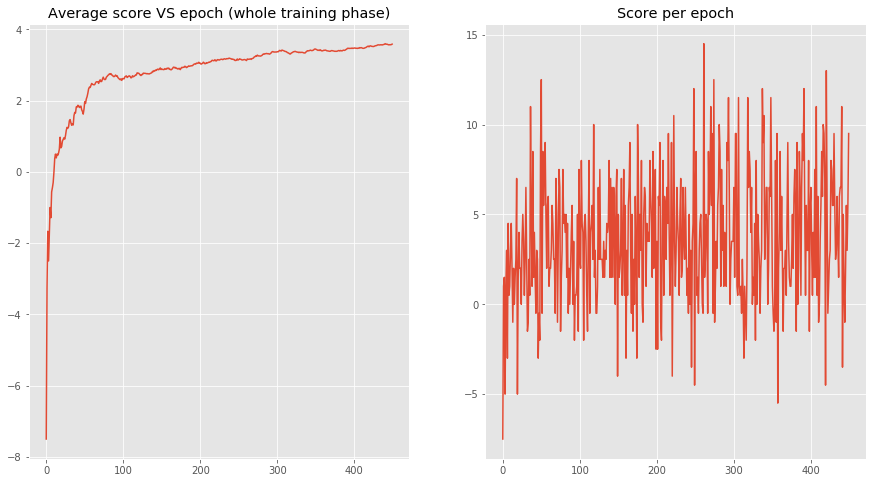

In [13]:

# parameters
size = 13
T=200
temperature=0.3
epochs_train=450 # set small when debugging
epochs_test=100 # set small when debugging
env = Environment(grid_size=size, max_time=T, temperature=0.3)
agent = DQN_FC(size, lr=.05, epsilon = 0.2, memory_size=2000, batch_size = 5)
train(agent, env, epochs_train, prefix='fc_train')


In [18]:
HTML(display_videos('fc_train400.mp4'))
#HTML(display_videos('fc_train10.mp4'))

***
***
__Question 8__ Implement the DQN training algorithm using a CNN (for example, 2 convolutional layers and one final fully connected layer).

In [0]:
class DQN_CNN(DQN):
    def __init__(self, *args,lr=0.1,**kwargs):
        super(DQN_CNN, self).__init__(*args,**kwargs)
        
        ###### FILL IN
        model = Sequential()
        model.add(Conv2D(80,(2,2),input_shape=(5,5,self.n_state),activation='relu'))
        # No use of maxpool, not relevant, grid is too small
        model.add(Conv2D(40,(2,2),activation='relu'))
        model.add(Conv2D(20,(2,2),activation='relu'))
        model.add(Flatten())
        model.add(Dense(units=64, activation='relu'))
        model.add(Dense(units=16, activation='relu'))
        model.add(Dense(units=4))

        model.compile(sgd(lr=lr, decay=1e-4, momentum=0.0), "mse")
        self.model = model

Epoch 000/450 | Loss 0.0025 | Win/lose count 4.5/7.0 (-2.5)
Epoch 001/450 | Loss 0.0094 | Win/lose count 5.0/4.0 (1.0)
Epoch 002/450 | Loss 0.0034 | Win/lose count 2.5/3.0 (-0.5)
Epoch 003/450 | Loss 0.0151 | Win/lose count 1.5/2.0 (-0.5)
Epoch 004/450 | Loss 0.0070 | Win/lose count 1.0/1.0 (0.0)
Epoch 005/450 | Loss 0.0107 | Win/lose count 0.5/1.0 (-0.5)
Epoch 006/450 | Loss 0.0074 | Win/lose count 2.5/2.0 (0.5)
Epoch 007/450 | Loss 0.0009 | Win/lose count 2.5/2.0 (0.5)
Epoch 008/450 | Loss 0.0022 | Win/lose count 3.5/5.0 (-1.5)
Epoch 009/450 | Loss 0.0015 | Win/lose count 3.5/1.0 (2.5)
Epoch 010/450 | Loss 0.0006 | Win/lose count 5.5/1.0 (4.5)
Epoch 011/450 | Loss 0.0021 | Win/lose count 8.5/4.0 (4.5)
Epoch 012/450 | Loss 0.0110 | Win/lose count 7.0/1.0 (6.0)
Epoch 013/450 | Loss 0.0038 | Win/lose count 3.0/2.0 (1.0)
Epoch 014/450 | Loss 0.0009 | Win/lose count 8.5/4.0 (4.5)
Epoch 015/450 | Loss 0.0045 | Win/lose count 4.5/3.0 (1.5)
Epoch 016/450 | Loss 0.0096 | Win/lose count 7.5/4.

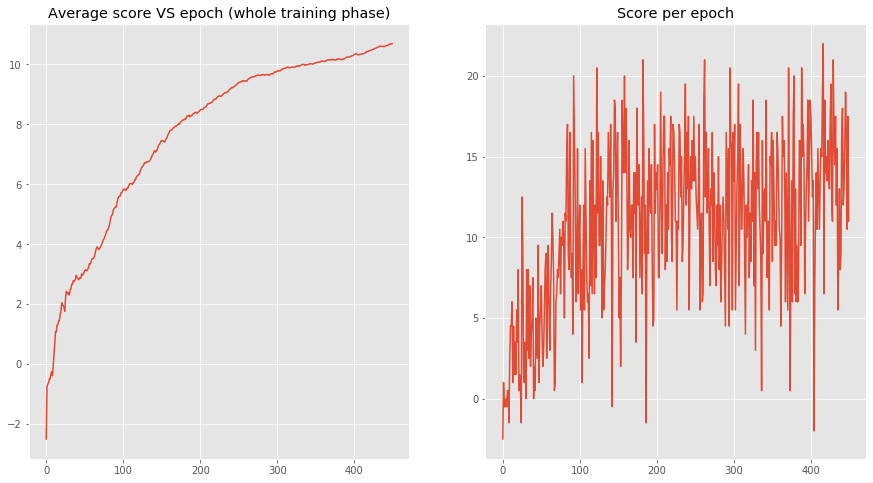

In [20]:
env = Environment(grid_size=size, max_time=T, temperature=0.25)
agent = DQN_CNN(size, lr=.08, epsilon = 0.1, memory_size=2000, batch_size = 32)
train(agent,env,epochs_train,prefix='cnn_train')


In [22]:
HTML(display_videos('cnn_train400.mp4'))

***
***
__Question 9__ Test both algorithms and compare their performances. Which issue(s) do you observe? Observe also different behaviors by changing the temperature.

In [23]:
env = Environment(grid_size=size, max_time=T,temperature=0.3)
agent_cnn = DQN_CNN(size, lr=.1, epsilon = 0.1, memory_size=2000, batch_size = 32)
agent_cnn.load(name_weights='cnn_trainmodel.h5',name_model='cnn_trainmodel.json')

agent_fc = DQN_FC(size, lr=.1, epsilon = 0.1, memory_size=2000, batch_size = 32)
agent_cnn.load(name_weights='fc_trainmodel.h5',name_model='fc_trainmodel.json')
print('Test of the CNN')
test(agent_cnn,env,epochs_test,prefix='cnn_test')
print('Test of the FC')
test(agent_fc,env,epochs_test,prefix='fc_test')

Test of the CNN
Win/lose count 3.0/3.0. Average score (0.0)
Win/lose count 1.5/1.0. Average score (0.25)
Win/lose count 1.5/0. Average score (0.6666666666666666)
Win/lose count 2.0/4.0. Average score (0.0)
Win/lose count 3.0/2.0. Average score (0.2)
Win/lose count 1.5/4.0. Average score (-0.25)
Win/lose count 5.0/4.0. Average score (-0.07142857142857142)
Win/lose count 1.0/2.0. Average score (-0.1875)
Win/lose count 3.0/4.0. Average score (-0.2777777777777778)
Win/lose count 2.5/5.0. Average score (-0.5)
Win/lose count 4.0/3.0. Average score (-0.36363636363636365)
Win/lose count 4.0/1.0. Average score (-0.08333333333333333)
Win/lose count 2.5/4.0. Average score (-0.19230769230769232)
Win/lose count 1.5/1.0. Average score (-0.14285714285714285)
Win/lose count 2.5/3.0. Average score (-0.16666666666666666)
Win/lose count 2.5/4.0. Average score (-0.25)
Win/lose count 2.5/2.0. Average score (-0.20588235294117646)
Win/lose count 2.5/2.0. Average score (-0.16666666666666666)
Win/lose count 2.

In [24]:
HTML(display_videos('cnn_test10.mp4'))

In [32]:
HTML(display_videos('fc_test10.mp4'))

<b>Comments:</b> The CNN is performing better than the multi-layer NN. This can be partially explained by the type of information we use as state. It a 5x5 grid. CNN are known to perform the best on grid(2D case) structured data (kind of an image in a sense). However, both algortihms are not **exploring** enough and don't seem to capture information about their surroundings.

<b>Temperature: </b> Changing the temperature has a direct impact on the binomials that are used to generate rewards (both **bonus** and **malus**). By increasing the temperature, we change the amount of information we got on the board.

***

The algorithm tends to not explore the map which can be an issue. We propose two ideas in order to encourage exploration:
1. Incorporating a decreasing $\epsilon$-greedy exploration. You can use the method ```set_epsilon```
2. Append via the environment a new state that describes if a cell has been visited or not

***
__Question 10__ Design a new ```train_explore``` function and environment class ```EnvironmentExploring``` to tackle the issue of exploration.



In [0]:
def train_explore(agent, env, epoch, start_eps, end_eps, prefix=''):
  """This new train_explore function has one major change from the orginal one based
  on the suggestions given in the question. 

  1) A dynamic has to be set for epsilon. Intuitively, the exploring parameter 
    should be high at the beginning of the training phase, and then decrease as we
    more and more can rely on our model's exploring behaviour. Hence, we change
    epsilon at each epoch.
  
  """
  # Number of won games
  score = 0
  loss = 0
  
  
  agent.set_epsilon(start_eps) # Start with a given eps

  
  score_epoch = []
  score_avg = []

  for e in range(epoch):
      # At each epoch, we restart to a fresh game and get the initial state
      state = env.reset()
      # This assumes that the games will terminate
      game_over = False

      win = 0
      lose = 0
      
      epsilon = ((end_eps-start_eps)/(epoch-1))*e + start_eps
      agent.set_epsilon(epsilon)

      while not game_over:
          # The agent performs an action
          action = agent.act(state)

          # Apply an action to the environment, get the next state, the reward
          # and if the games end
          prev_state = state

          
          state, reward, game_over = env.act(action, train=True) ## Suggested
          

          # Update the counters
          if reward > 0:
              win = win + reward
          if reward < 0:
              lose = lose -reward

          # Apply the reinforcement strategy
          loss = agent.reinforce(prev_state, state,  action, reward, game_over)

      
      # Save as a mp4
      if e % 50 == 0:
          env.draw(prefix+str(e))
      score_epoch.append(win-lose)
      if(e>0):
        score_avg.append(score_avg[-1]*(e/(e+1)) + (win-lose)/(e+1))
      else :
        score_avg.append(win-lose)
      # Update stats
      score += win-lose
      
      
      print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win/lose count {:04.1f}/{:04.1f} ({:+05.1f})".format(e+1, epoch, loss, win, lose, win-lose))
      
      
      
  agent.save(name_weights=prefix+'model.h5',name_model=prefix+'model.json')
  display_stats_run(score_avg,score_epoch)
  

class EnvironmentExploring(object):
    def __init__(self, grid_size=10, max_time=500, temperature=0.1):
      """Same init as before"""
      grid_size = grid_size+4
      self.grid_size = grid_size
      self.max_time = max_time
      self.temperature = temperature

      #board on which one plays
      self.board = np.zeros((grid_size,grid_size))
      self.position = np.zeros((grid_size,grid_size))
      self.malus_position = np.zeros((grid_size,grid_size))
      
      # coordinate of the rat
      self.x = 0
      self.y = 1
      
      # self time
      self.t = 0
      
      self.scale=16

      self.to_draw = np.zeros((max_time+2, grid_size*self.scale, grid_size*self.scale, 3))

    def draw(self,e):
      """Same as before"""
      skvideo.io.vwrite(str(e) + '.mp4', self.to_draw)

    def get_frame(self,t):
      """Same as before"""
      b = np.zeros((self.grid_size,self.grid_size,3))+128
      b[self.board > 0,0] = 256
      b[self.board < 0,2] = 256
      b[self.x,self.y,:] = 256
      b[-2:,:,:]=0
      b[:,-2:,:]=0
      b[:2,:,:]=0
      b[:,:2,:]=0
      
      b =  cv2.resize(b, None, fx=self.scale, fy=self.scale, interpolation=cv2.INTER_NEAREST)

      self.to_draw[t,:,:,:]=b
    


    def act(self, action, train=False):
        """Several changes in this function. First we added an argument train to ...
        Then there are several changes from the suggestions :
        1) First of all, if we are in training phase, we observe a malus for positions
          we already visited.
        2) States are now taking 3 type of features as arguments"""

        self.get_frame(int(self.t))

        self.position = np.zeros((self.grid_size, self.grid_size))
        
        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:,:] = -1
        self.position[:,-2:] = -1

        self.position[self.x, self.y] = 1
        
        if action == 0:
            if self.x == self.grid_size - 3:
                self.x = self.x-1
            else:
                self.x = self.x + 1
        elif action == 1:
            if self.x == 2:
                self.x = self.x+1
            else:
                self.x = self.x-1
        elif action == 2:
            if self.y == self.grid_size - 3:
                self.y = self.y - 1
            else:
                self.y = self.y + 1
        elif action == 3:
            if self.y == 2:
                self.y = self.y + 1
            else:
                self.y = self.y - 1
        else:
            RuntimeError('Error: action not recognized')
        self.t = self.t + 1
        
        ## If in training, we penalize the agent for visiting same states. 
        reward = 0
        if train:
            reward = -self.malus_position[self.x, self.y]
        self.malus_position[self.x, self.y] = 0.1
        reward = reward + self.board[self.x, self.y]

        
        self.board[self.x, self.y] = 0
        game_over = self.t > self.max_time
        
        ## 3 type of features instead of 2
        state = np.concatenate((self.malus_position.reshape(self.grid_size, self.grid_size,1),
                                self.board.reshape(self.grid_size, self.grid_size,1),
                        self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)
        
        state = state[self.x-2:self.x+3,self.y-2:self.y+3,:]

        return state, reward, game_over


    def reset(self):
        """One change : 
        1) state is now taking 3 type of features as arguments."""
        
        self.x = np.random.randint(3, self.grid_size-3, size=1)[0]
        self.y = np.random.randint(3, self.grid_size-3, size=1)[0]

        bonus = 0.5*np.random.binomial(1,self.temperature, size=self.grid_size**2)
        bonus = bonus.reshape(self.grid_size, self.grid_size)

        malus = -1.0*np.random.binomial(1,self.temperature, size=self.grid_size**2)
        malus = malus.reshape(self.grid_size, self.grid_size)

        self.to_draw = np.zeros((self.max_time+2, self.grid_size*self.scale, self.grid_size*self.scale, 3))

        malus[bonus>0]=0
        
        self.board = bonus + malus

        self.position = np.zeros((self.grid_size, self.grid_size))
        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:, :] = -1
        self.position[:,-2:] = -1
        
        self.board[self.x,self.y] = 0
        self.t = 0


        state = np.concatenate((self.malus_position.reshape(self.grid_size, self.grid_size,1),
                                self.board.reshape(self.grid_size, self.grid_size,1),
                        self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)
        
        state = state[self.x - 2:self.x + 3, self.y - 2:self.y + 3, :]
        
        return state













Epoch 001/450 | Loss 0.0121 | Win/lose count 07.0/23.5 (-16.5)
Epoch 002/450 | Loss 0.0114 | Win/lose count 04.5/22.2 (-17.7)
Epoch 003/450 | Loss 0.0029 | Win/lose count 04.3/23.3 (-19.0)
Epoch 004/450 | Loss 0.0060 | Win/lose count 06.9/22.5 (-15.6)
Epoch 005/450 | Loss 0.0050 | Win/lose count 04.1/22.0 (-17.9)
Epoch 006/450 | Loss 0.0053 | Win/lose count 08.1/23.1 (-15.0)
Epoch 007/450 | Loss 0.0137 | Win/lose count 10.3/21.0 (-10.7)
Epoch 008/450 | Loss 0.0059 | Win/lose count 07.7/22.7 (-15.0)
Epoch 009/450 | Loss 0.0026 | Win/lose count 08.4/20.9 (-12.5)
Epoch 010/450 | Loss 0.0046 | Win/lose count 11.3/22.2 (-10.9)
Epoch 011/450 | Loss 0.0126 | Win/lose count 08.1/27.7 (-19.6)
Epoch 012/450 | Loss 0.0200 | Win/lose count 08.6/25.5 (-16.9)
Epoch 013/450 | Loss 0.0162 | Win/lose count 06.1/25.4 (-19.3)
Epoch 014/450 | Loss 0.0052 | Win/lose count 08.0/27.0 (-19.0)
Epoch 015/450 | Loss 0.0224 | Win/lose count 07.5/24.9 (-17.4)
Epoch 016/450 | Loss 0.0085 | Win/lose coun

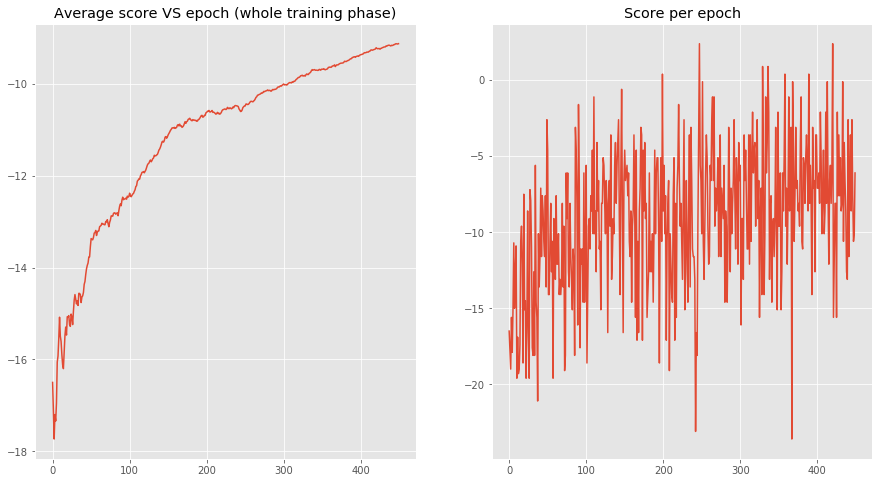

In [16]:
# Training
env = EnvironmentExploring(grid_size=size, max_time=T, temperature=0.25)
agent_exp = DQN_CNN(size, lr=.1, epsilon = 0.1, memory_size=2000, batch_size = 32,n_state=3)
#agent_exp.load(name_weights='cnn_train_exploremodel.h5', name_model='cnn_train_exploremodel.json')
train_explore(agent_exp, env, epochs_train,start_eps = 0.3, end_eps = 0.02, prefix='cnn_train_explore')


In [17]:
HTML(display_videos('cnn_train_explore400.mp4'))
# We can notice that the agent has learnt to explore significantly more than before.

In [19]:
# Evaluation
test(agent_exp,env,epochs_test,prefix='cnn_test_explore')
HTML(display_videos('cnn_test_explore10.mp4'))

Win/lose count 1.0/0. Average score (1.0)
Win/lose count 1.0/1.0. Average score (0.5)
Win/lose count 1.0/3.0. Average score (-0.3333333333333333)
Win/lose count 1.5/2.0. Average score (-0.375)
Win/lose count 2.0/1.0. Average score (-0.1)
Win/lose count 2.0/2.0. Average score (-0.08333333333333333)
Win/lose count 1.5/0. Average score (0.14285714285714285)
Win/lose count 2.0/1.0. Average score (0.25)
Win/lose count 2.5/0. Average score (0.5)
Win/lose count 1.0/1.0. Average score (0.45)
Win/lose count 3.0/1.0. Average score (0.5909090909090909)
Win/lose count 0.5/2.0. Average score (0.4166666666666667)
Win/lose count 2.5/2.0. Average score (0.4230769230769231)
Win/lose count 2.5/3.0. Average score (0.35714285714285715)
Win/lose count 2.0/3.0. Average score (0.26666666666666666)
Win/lose count 2.5/1.0. Average score (0.34375)
Win/lose count 2.5/0. Average score (0.47058823529411764)
Win/lose count 1.0/1.0. Average score (0.4444444444444444)
Win/lose count 1.0/2.0. Average score (0.36842105

***
***
__BONUS question__ Use the expert DQN from the previous question to generate some winning games. Train a model that mimicks its behavior. Compare the performances.

In [0]:
def train_mimick(agent, expert, env, epoch, prefix=''):
  """Here, we only add the expert as an argument and change the way it selects 
      actions. Now we follow the expert's policy."""
  score = 0
  loss = 0
  
  score_epoch = []
  score_avg = []

  for e in range(epoch):
      state = env.reset()
      game_over = False

      win = 0
      lose = 0

      while not game_over:

          # action = agent.act(state)
          action = expert.act(state) ## following expert policy

          prev_state = state
          state, reward, game_over = env.act(action, train=True)

          if reward > 0:
              win = win + reward
          if reward < 0:
              lose = lose -reward

          loss = agent.reinforce(prev_state, state,  action, reward, game_over)


      score += win-lose
      score_epoch.append(win-lose)
      if(e>0):
        score_avg.append(score_avg[-1]*(e/(e+1)) + (win-lose)/(e+1))
      else :
        score_avg.append(win-lose)
      
        
      print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win/lose count {:04.1f}/{:04.1f} ({:+05.1f})".format(e+1, epoch, loss, win, lose, win-lose))
        
      
  agent.save(name_weights=prefix+'model.h5',name_model=prefix+'model.json')
  display_stats_run(score_avg,score_epoch)
  env.draw(prefix+str(epoch))
  
  
  print('Final score: '+str(score/epoch))

Epoch 001/450 | Loss 0.0039 | Win/lose count 18.5/19.0 (-00.5)
Epoch 002/450 | Loss 0.0014 | Win/lose count 15.6/20.7 (-05.1)
Epoch 003/450 | Loss 0.0029 | Win/lose count 18.3/19.6 (-01.3)
Epoch 004/450 | Loss 0.0186 | Win/lose count 13.4/20.7 (-07.3)
Epoch 005/450 | Loss 0.0250 | Win/lose count 15.6/24.0 (-08.4)
Epoch 006/450 | Loss 0.0143 | Win/lose count 17.2/19.7 (-02.5)
Epoch 007/450 | Loss 0.0071 | Win/lose count 13.2/22.8 (-09.6)
Epoch 008/450 | Loss 0.0063 | Win/lose count 14.9/25.2 (-10.3)
Epoch 009/450 | Loss 0.0036 | Win/lose count 04.4/24.0 (-19.6)
Epoch 010/450 | Loss 0.0043 | Win/lose count 04.4/22.0 (-17.6)
Epoch 011/450 | Loss 0.0035 | Win/lose count 14.0/20.6 (-06.6)
Epoch 012/450 | Loss 0.2211 | Win/lose count 06.4/25.5 (-19.1)
Epoch 013/450 | Loss 0.0062 | Win/lose count 12.4/22.0 (-09.6)
Epoch 014/450 | Loss 0.0032 | Win/lose count 11.6/22.2 (-10.6)
Epoch 015/450 | Loss 0.0015 | Win/lose count 12.4/21.0 (-08.6)
Epoch 016/450 | Loss 0.0091 | Win/lose count 10.0/25.6 

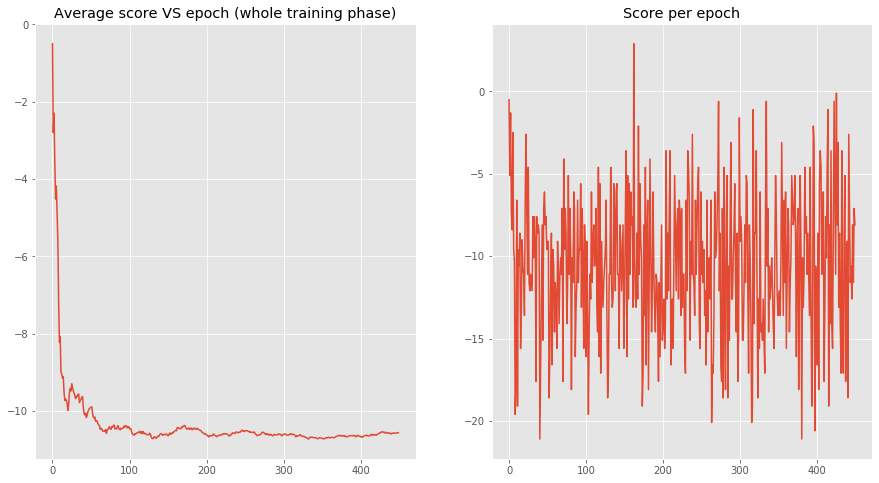

In [21]:
env_mimick_train = EnvironmentExploring(grid_size=size, max_time=T, temperature=0.25)

# we define the expert
expert = DQN_CNN(size, lr=.1, epsilon = 0.2, memory_size=2000, batch_size = 1, n_state=3)
expert.load(name_weights='cnn_train_exploremodel.h5', name_model='cnn_train_exploremodel.json')

# we define the mimick agent
agent_mimick_train = DQN_CNN(size, lr=.1, epsilon = 0.2, memory_size=2000, batch_size = 1, n_state=3)

# we train the mimick agent, who will learn from the expert
train_mimick(agent_mimick_train, expert, env_mimick_train, 450, prefix='cnn_train_mimick')



In [22]:
HTML(display_videos('cnn_train_mimick'+str(450)+'.mp4'))

In [23]:
epochs_test = 100

env_mimick_test = EnvironmentExploring(grid_size=size, max_time=T, temperature=0.25)

agent_mimick_test = DQN_CNN(size, lr=.1, epsilon = 0.2, memory_size=2000, batch_size = 1, n_state=3)
agent_mimick_test.load(name_weights='cnn_train_mimickmodel.h5', name_model='cnn_train_mimickmodel.json')

test(agent_mimick_test, env_mimick_test, epochs_test, prefix='cnn_test_mimick')



Win/lose count 1.5/3.0. Average score (-1.5)
Win/lose count 2.5/4.0. Average score (-1.5)
Win/lose count 2.5/6.0. Average score (-2.1666666666666665)
Win/lose count 1.0/2.0. Average score (-1.875)
Win/lose count 2.5/3.0. Average score (-1.6)
Win/lose count 2.5/4.0. Average score (-1.5833333333333333)
Win/lose count 3.0/8.0. Average score (-2.0714285714285716)
Win/lose count 1.5/1.0. Average score (-1.75)
Win/lose count 3.0/2.0. Average score (-1.4444444444444444)
Win/lose count 3.5/3.0. Average score (-1.25)
Win/lose count 1.5/4.0. Average score (-1.3636363636363635)
Win/lose count 1.0/2.0. Average score (-1.3333333333333333)
Win/lose count 2.5/0. Average score (-1.0384615384615385)
Win/lose count 2.5/4.0. Average score (-1.0714285714285714)
Win/lose count 2.0/2.0. Average score (-1.0)
Win/lose count 4.5/3.0. Average score (-0.84375)
Win/lose count 2.5/4.0. Average score (-0.8823529411764706)
Win/lose count 3.5/1.0. Average score (-0.6944444444444444)
Win/lose count 2.5/2.0. Average sc

In [24]:
HTML(display_videos('cnn_test_mimick'+str(99)+'.mp4'))

---

<b>Comments : </b>
First, the explorer agent is able to better explore the board game, and thus beat the basic CNN model. However, its superiority is not significant. Performance may be bossted by tuning hyper-parameters. 

<b> Bonus question :</b>
We observe that the mimick agent is not able to perform better than the expert. This technique is known as **Behavioural Cloning** and can works well in certain applications but has serious limitations (e.g. if making errors is critical can lead to bad results).
We 


---


***